In [1]:
import pickle
import numpy as np
import scvelo as scv
import scanpy
import torch

from veloproj import *

scv.settings.verbosity = 1

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-6',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               '--data-dir', '/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad',
                               '--model-name', 'scNT_model_gat.cpt',
                               '--exp-name', 'CohAE_scNT_gat',
                               '--device', 'cuda:3',
                               '--gumbsoft_tau', '5',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "SU",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'time',
                               '--scv_n_jobs', '10',
                              ])
args                              

Namespace(adata=None, aux_weight=1.0, conv_thred=1e-06, data_dir='/data/groups/yhhuang/scNT/neuron_splicing_lite.h5ad', device='cuda:3', exp_name='CohAE_scNT_gat', fit_offset_pred=True, fit_offset_train=False, g_rep_dim=100, gnn_layer='GAT', gumbsoft_tau=5.0, h_dim=256, k_dim=100, ld_adata='projection.h5', ld_nb_g_src='SU', log_interval=100, lr=1e-06, lr_decay=0.9, mask_cluster_list=None, model_name='scNT_model_gat.cpt', n_conn_nb=30, n_epochs=20000, n_nb_newadata=30, n_raw_gene=2000, nb_g_src='SU', output='./', refit=True, scv_n_jobs=10, seed=42, sl1_beta=1.0, use_norm=False, use_offset_pred=False, use_x=False, v_rg_wt=0.0, vis_key='X_umap', vis_type_col='time', weight_decay=0.0, z_dim=100)

In [3]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [4]:
cluster_edges = [("0", "15"), ("15", "30"), ("30", "60"), ("60", "120")]
EXP_NAME = args.exp_name
exp_metrics = {}

In [5]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['stc_velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

In [6]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
adata.obs['time'] = adata.obs.time.astype('category')
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
print(adata)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]
AnnData object with n_obs × n_vars = 3066 × 2000
    obs: 'cellname', 'time', 'early', 'late', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'gene_short_name', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'pca', 'neighbors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


or disable the progress bar using `show_progress_bar=False`.


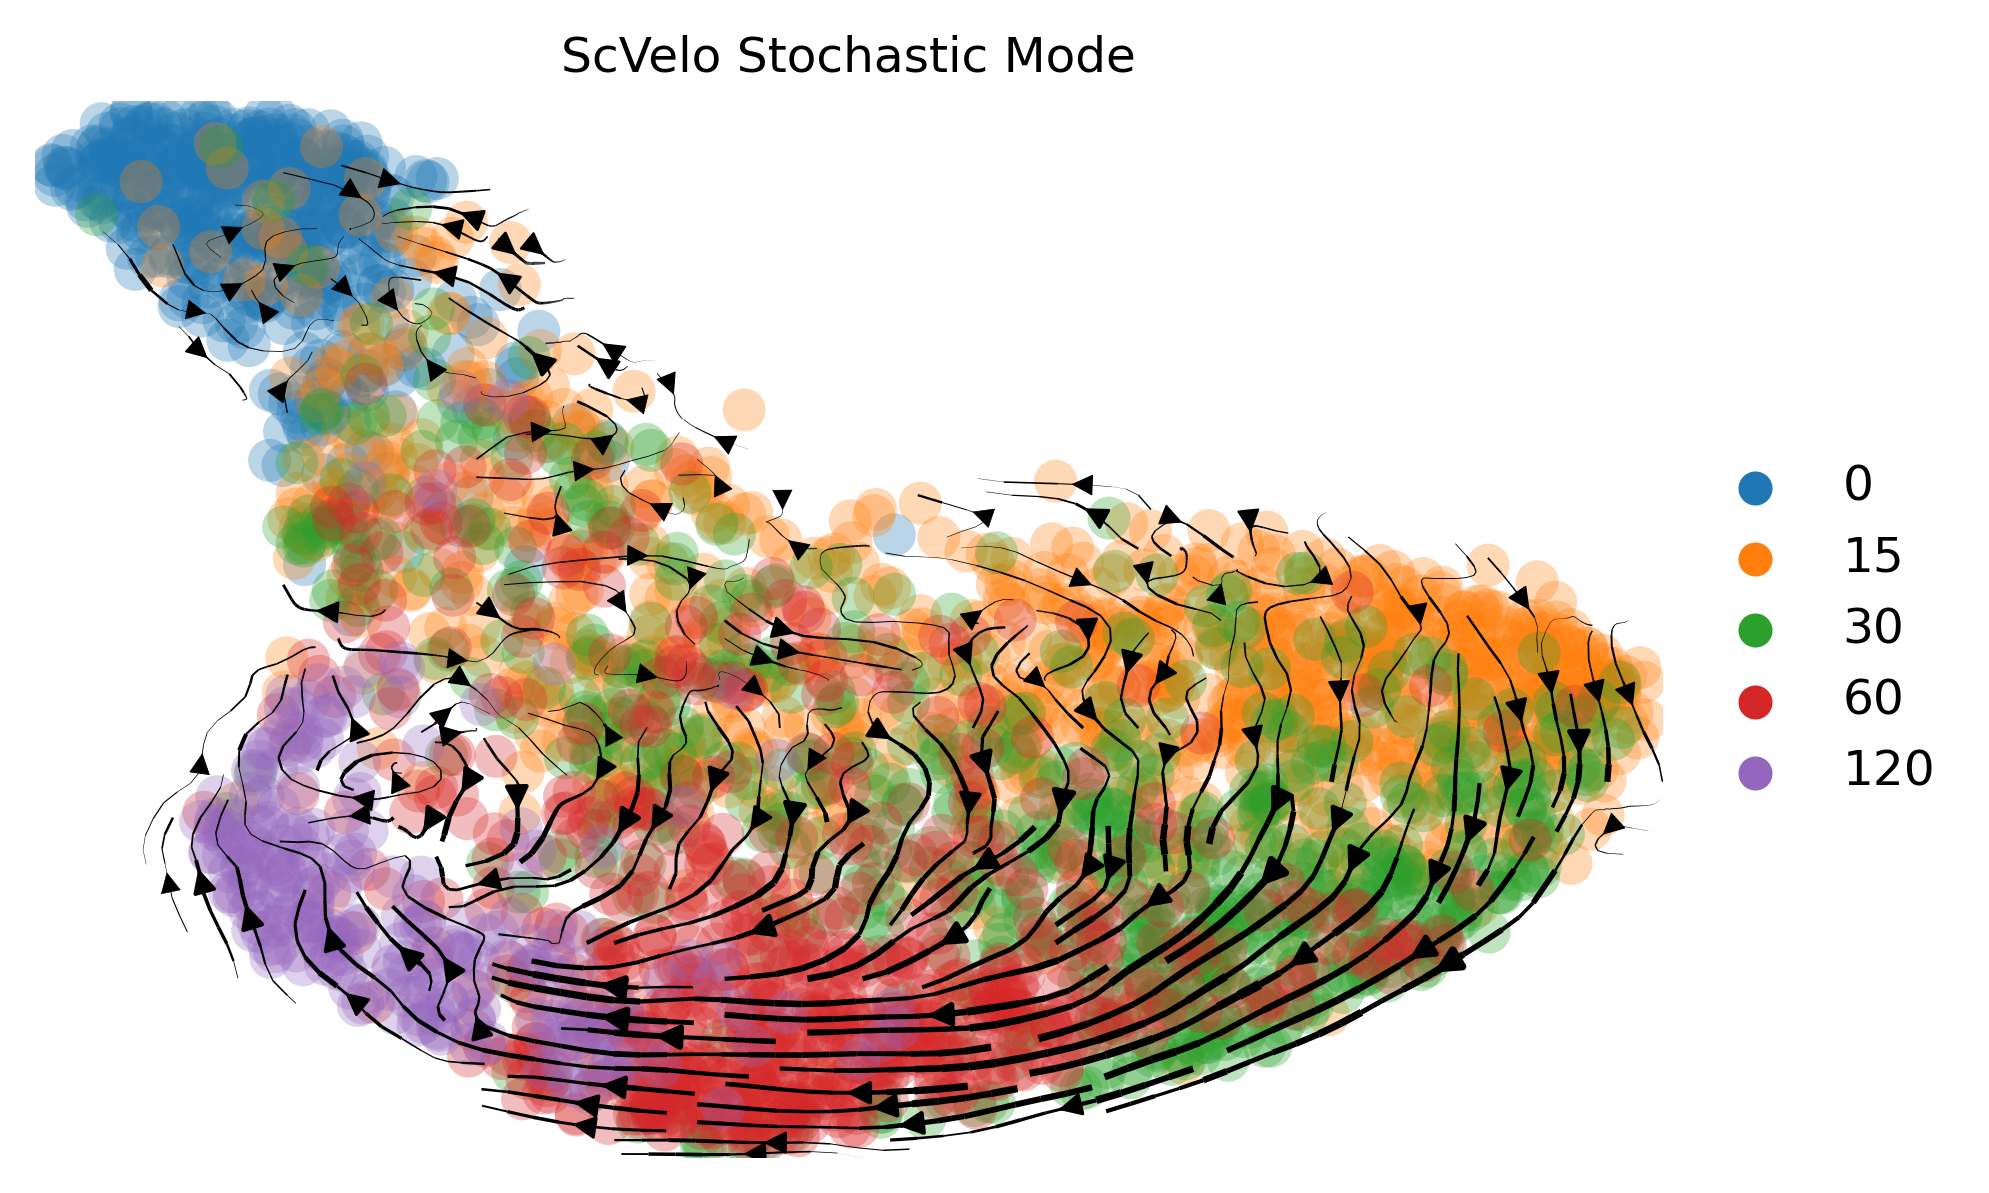

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.18047157, ('15', '30'): 0.18490802, ('30', '60'): 0.23314989, ('60', '120'): 0.26255786}
Total Mean: 0.21527183055877686
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.88223696, ('15', '30'): 0.84970397, ('30', '60'): 0.8860251, ('60', '120'): 0.94955367}
Total Mean: 0.8918799757957458
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.18783866728038073, ('15', '30'): 0.18306440173278263, ('30', '60'): 0.26049541483633637, ('60', '120'): 0.37984779675136643}
Total Mean: 0.25281157015021655
# In-cluster Coherence
{'0': 0.9150234, '120': 0.96112585, '15': 0.8693803, '30': 0.8747749, '60': 0.9513406}
Total Mean: 0.914328932762146
# In-cluster Confidence
{'0': 0.5655337789948088, '120': 0.521150084383103, '15': 0.5152825943618544, '30': 0.5523610207691312, '60': 0.6307097623065673}
Total Mean: 0.5570074481630929


In [7]:
scv.tl.velocity(adata, vkey='stc_velocity', mode="stochastic")
scv.tl.velocity_graph(adata, vkey='stc_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='stc_velocity')
scv.pl.velocity_embedding_stream(adata,  legend_loc="right margin", vkey="stc_velocity", basis=args.vis_key, color=args.vis_type_col,
                                 dpi=350, 
                                title='ScVelo Stochastic Mode')
exp_metrics["stc_mode"] = evaluate(adata, cluster_edges, args.vis_type_col, "stc_velocity")

Train Epoch: 100/20000 	Loss: 6.056064
Train Epoch: 200/20000 	Loss: 6.031167
Train Epoch: 300/20000 	Loss: 5.997239
Train Epoch: 400/20000 	Loss: 5.956975
Train Epoch: 500/20000 	Loss: 5.896011
Train Epoch: 600/20000 	Loss: 5.799234
Train Epoch: 700/20000 	Loss: 5.684732
Train Epoch: 800/20000 	Loss: 5.537334
Train Epoch: 900/20000 	Loss: 5.370184
Train Epoch: 1000/20000 	Loss: 5.230238
Train Epoch: 1100/20000 	Loss: 5.111913
Train Epoch: 1200/20000 	Loss: 5.014518
Train Epoch: 1300/20000 	Loss: 4.924435
Train Epoch: 1400/20000 	Loss: 4.825282
Train Epoch: 1500/20000 	Loss: 4.719435
Train Epoch: 1600/20000 	Loss: 4.618449
Train Epoch: 1700/20000 	Loss: 4.522095
Train Epoch: 1800/20000 	Loss: 4.428693
Train Epoch: 1900/20000 	Loss: 4.329228
Train Epoch: 2000/20000 	Loss: 4.223564
Train Epoch: 2100/20000 	Loss: 4.128070
Train Epoch: 2200/20000 	Loss: 4.034333
Train Epoch: 2300/20000 	Loss: 3.947502
Train Epoch: 2400/20000 	Loss: 3.865223
Train Epoch: 2500/20000 	Loss: 3.777500
Train Epo

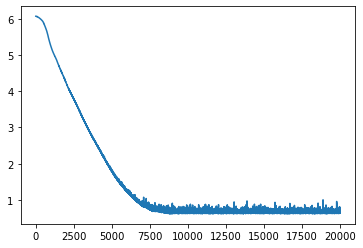

In [8]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

saving figure to file ./figures/scvelo_scNT_pojection.png


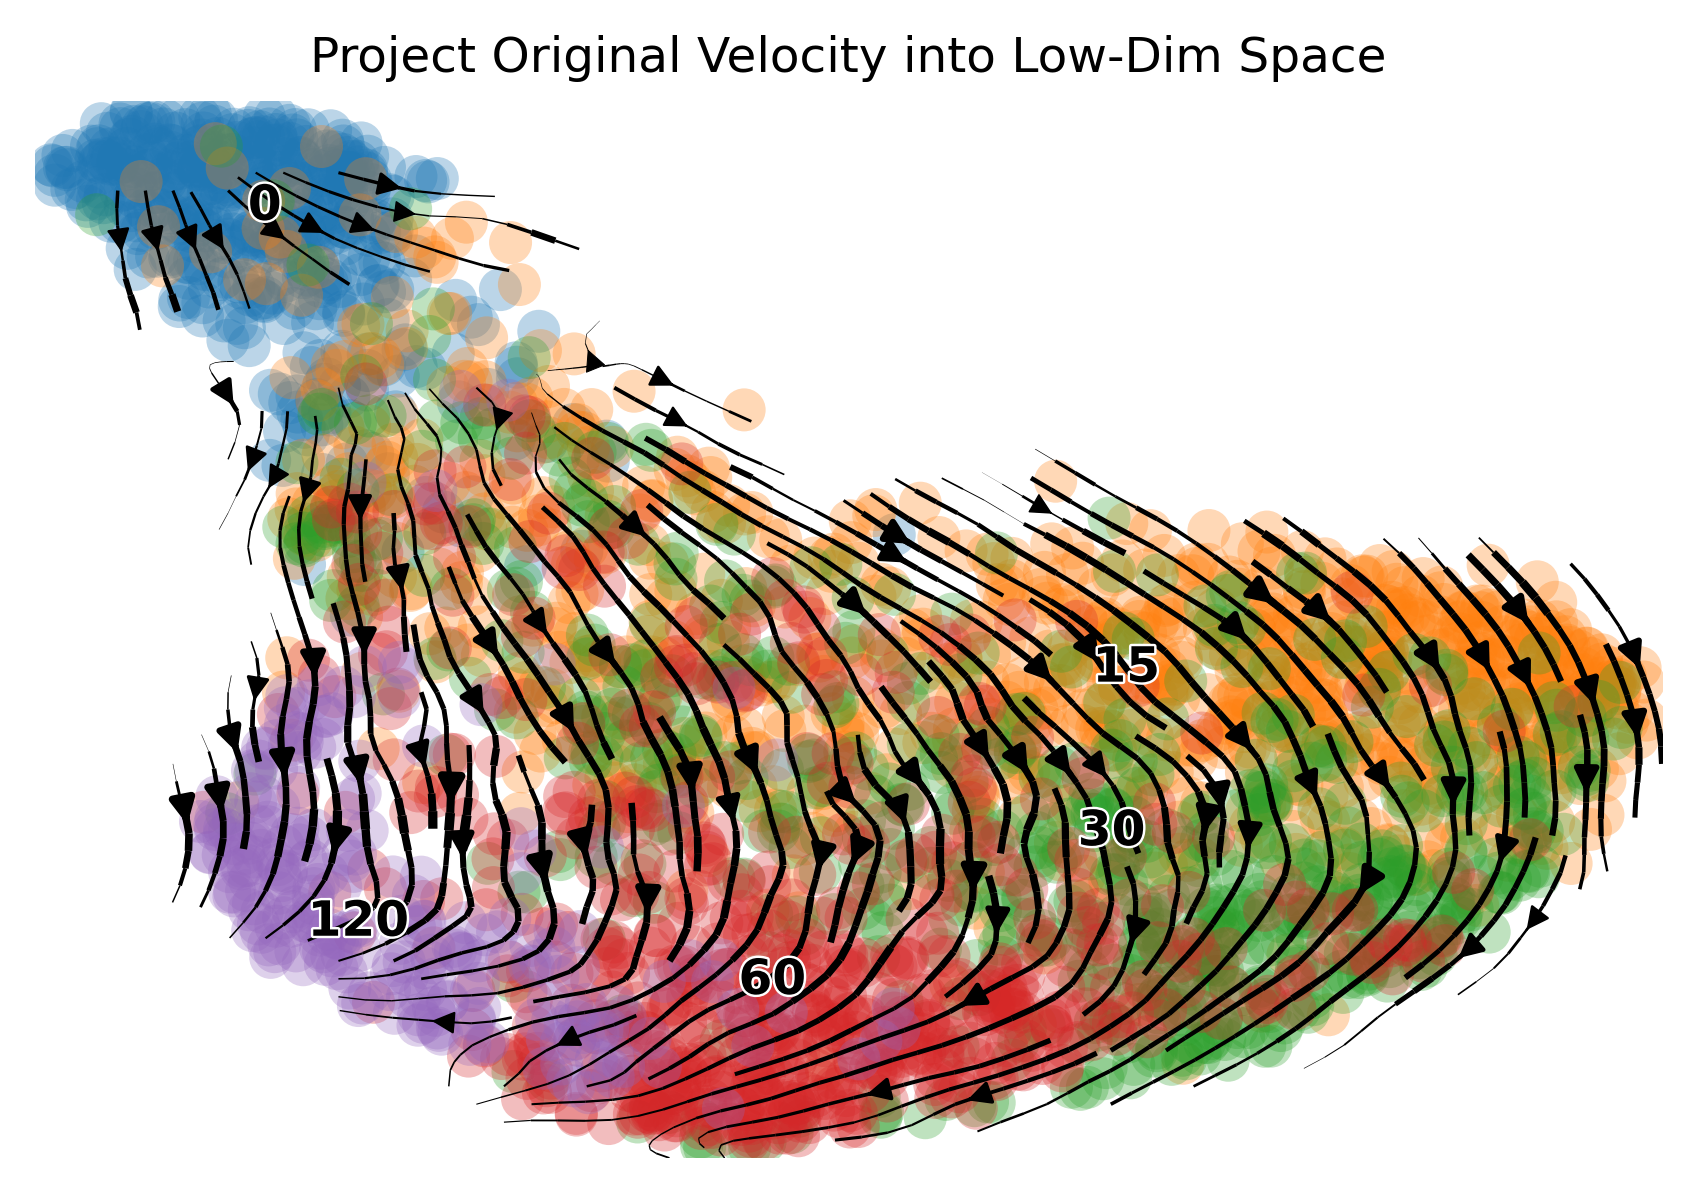

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.68258023, ('15', '30'): 0.6876652, ('30', '60'): 0.6681869, ('60', '120'): 0.6864574}
Total Mean: 0.6812224388122559
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.99998164, ('15', '30'): 0.99998236, ('30', '60'): 0.9999689, ('60', '120'): 0.9999652}
Total Mean: 0.9999744892120361
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.5720491758355138, ('15', '30'): 0.408425888566408, ('30', '60'): 0.28355930306557176, ('60', '120'): 0.2792156892686723}
Total Mean: 0.38581251418404144
# In-cluster Coherence
{'0': 0.99998516, '120': 0.9999811, '15': 0.9999847, '30': 0.99998313, '60': 0.99997336}
Total Mean: 0.9999815225601196
# In-cluster Confidence
{'0': 0.9999824039621374, '120': 0.999971750960407, '15': 0.9999832928492761, '30': 0.9999800353454781, '60': 0.9999636273390965}
Total Mean: 0.9999762220912791


In [9]:
def exp(adata, exp_metrics):
    model = init_model(adata, args, device)
    model.load_state_dict(torch.load(args.model_name))
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        x = model.encoder(tensor_x)
        s = model.encoder(tensor_s)
        u = model.encoder(tensor_u)
        
        v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                 norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                 use_offset=args.use_offset_pred
                                 ).cpu().numpy()
        x = x.cpu().numpy()
        s = s.cpu().numpy()
        u = u.cpu().numpy()
    
    adata = new_adata(adata, x, s, u, v, g_basis=args.ld_nb_g_src, n_nb_newadata=args.n_nb_newadata)
    scv.tl.velocity_graph(adata, vkey='new_velocity', n_jobs=args.scv_n_jobs)
    scv.pl.velocity_embedding_stream(adata, vkey="new_velocity", basis=args.vis_key, color=args.vis_type_col,
                                    title="Project Original Velocity into Low-Dim Space",
                                    dpi=350,
                                    save='scNT_pojection.png')  
    scv.tl.velocity_confidence(adata, vkey='new_velocity')
    exp_metrics['Cohort AutoEncoder'] = evaluate(adata, cluster_edges, args.vis_type_col, "new_velocity")
    
exp(adata, exp_metrics)

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


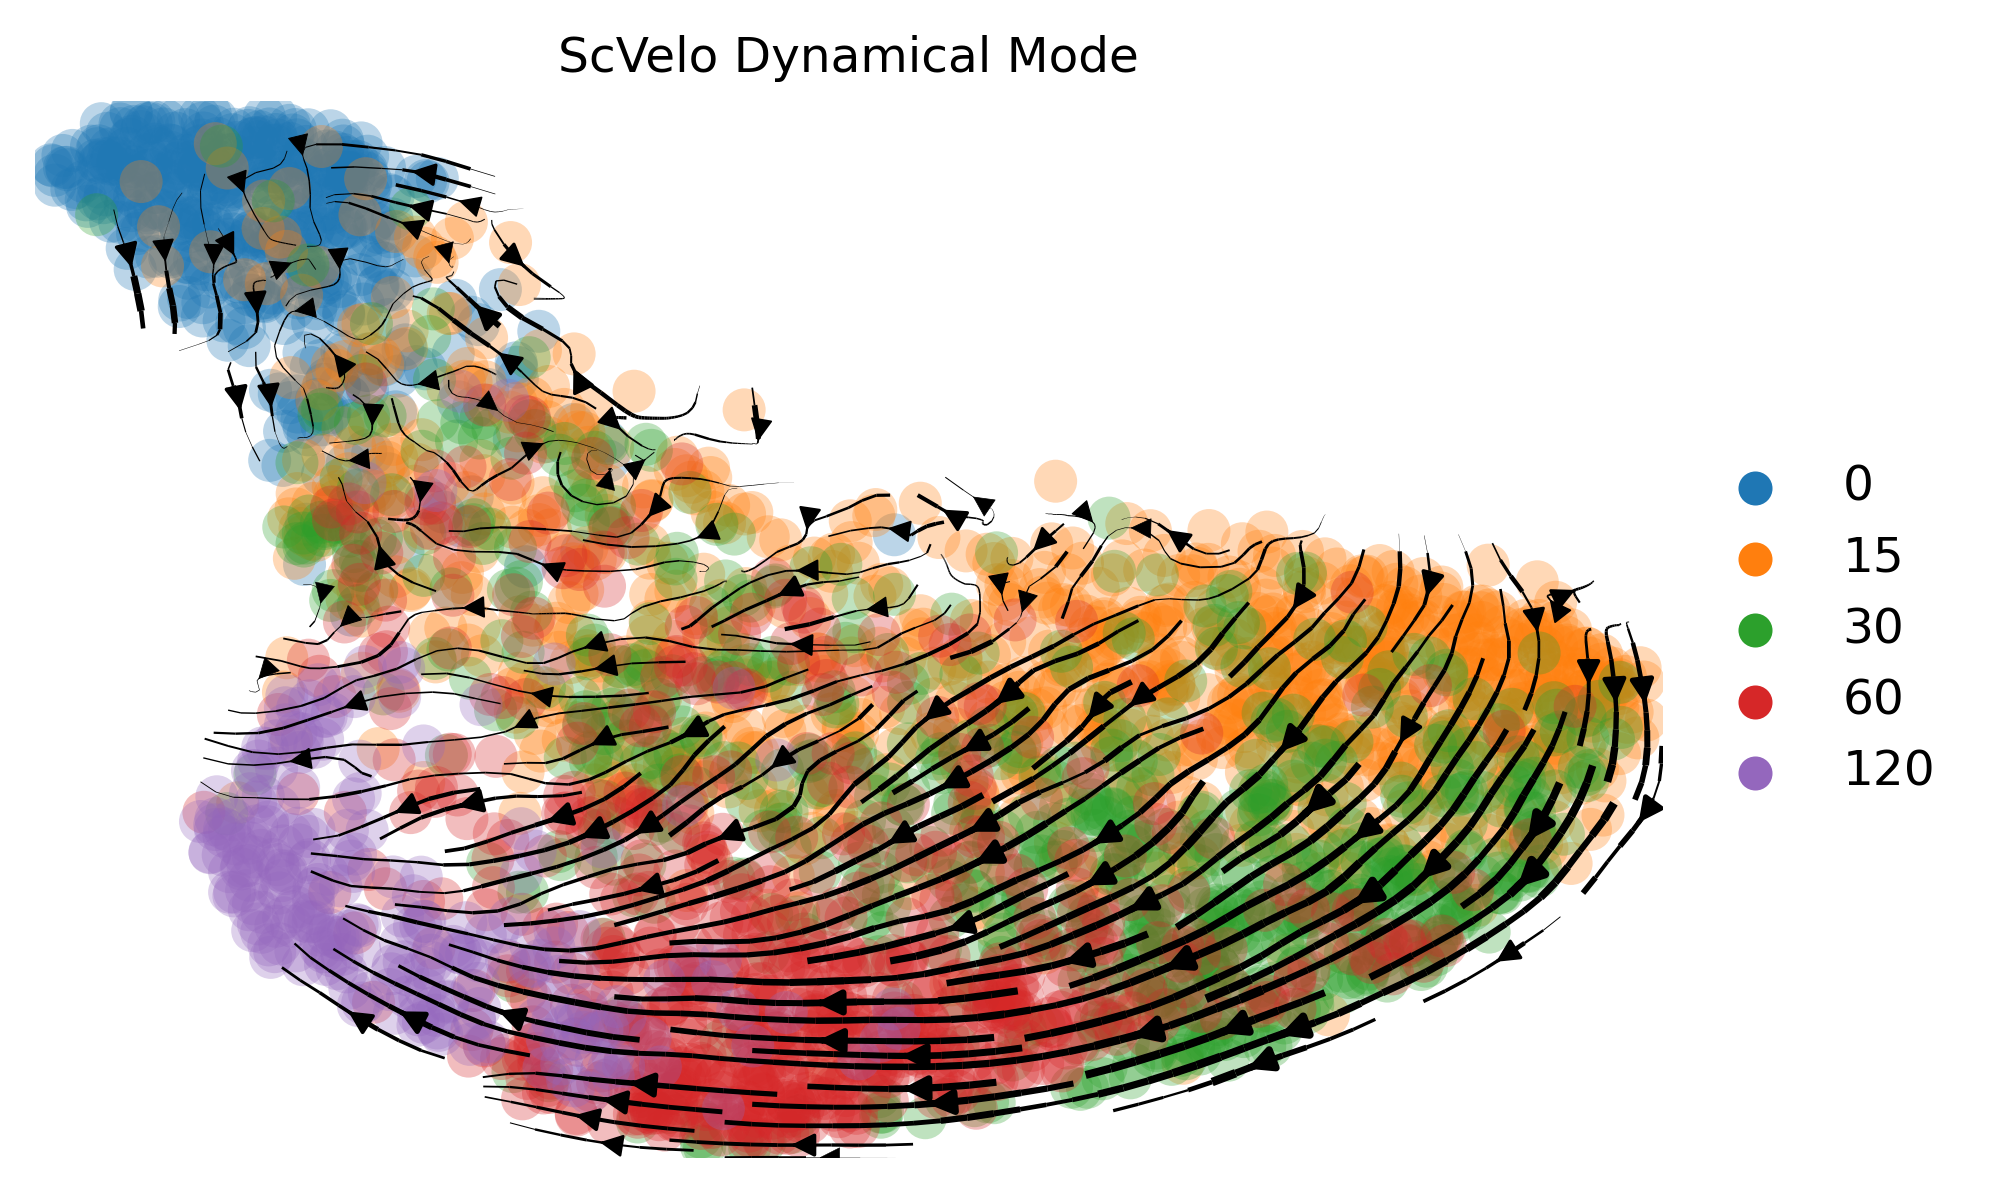

# Cross-Boundary Transition Score (A->B)
{('0', '15'): 0.060788855, ('15', '30'): 0.11320925, ('30', '60'): 0.22263485, ('60', '120'): 0.25826997}
Total Mean: 0.16372573375701904
# Cross-Boundary Velocity Coherence (A->B)
{('0', '15'): 0.7013783286498115, ('15', '30'): 0.8379523023119446, ('30', '60'): 0.8389419748429431, ('60', '120'): 0.8129241524987804}
Total Mean: 0.7977991895758699
# Cross-Boundary Direction Correctness (A->B)
{('0', '15'): 0.040799015852803676, ('15', '30'): 0.2634932136901216, ('30', '60'): 0.30032839501056885, ('60', '120'): 0.48262809563784165}
Total Mean: 0.2718121800478339
# In-cluster Coherence
{'0': 0.818761801665884, '120': 0.8712723813096704, '15': 0.8417682324225757, '30': 0.8842694906803218, '60': 0.8732170315752988}
Total Mean: 0.8578577875307503
# In-cluster Confidence
{'0': 0.7757721442988325, '120': 0.8518105601493391, '15': 0.8212857506457657, '30': 0.8595081271087779, '60': 0.8580811969631114}
Total Mean: 0.8332915558331653


In [10]:
adata = scanpy.read_h5ad(args.data_dir)
scv.utils.show_proportions(adata)
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=args.n_raw_gene)
scv.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=args.scv_n_jobs)
scv.tl.velocity(adata, vkey='dyn_velocity', mode="dynamical")

scv.tl.velocity_graph(adata, vkey='dyn_velocity', n_jobs=args.scv_n_jobs)
scv.tl.velocity_confidence(adata, vkey='dyn_velocity')
scv.pl.velocity_embedding_stream(adata,  
                                legend_loc="right margin", 
                                vkey="dyn_velocity", 
                                basis=args.vis_key, 
                                color=[args.vis_type_col],
                                dpi=350, 
                                title='ScVelo Dynamical Mode')
exp_metrics["dyn_mode"] = evaluate(adata[:, adata.var.dyn_velocity_genes], cluster_edges, args.vis_type_col, "dyn_velocity")

In [11]:
with open("{}.pkl".format(EXP_NAME), 'wb') as out_file:
    pickle.dump(exp_metrics, out_file)